# Prepare Dataset

In [68]:
import os

base_dir = "../datasets/"
samples_dir = os.path.join(base_dir, 'samples/')

# Datasets Dir
corn_dir = os.path.join(samples_dir, 'corn/')
weed_dir = os.path.join(samples_dir, 'weed/')

# Train, Test, Validation Dir
train_dir = os.path.join(base_dir, 'train/')
test_dir = os.path.join(base_dir, 'test/')

# Train, Test, Validation Corn Dir
train_corn_dir = os.path.join(train_dir, 'corn/')
test_corn_dir = os.path.join(test_dir, 'corn/')

# Train, Test, Validation Weed Dir
train_weed_dir = os.path.join(train_dir, 'weed/')
test_weed_dir = os.path.join(test_dir, 'weed/')

In [69]:
import random
from shutil import copyfile


def split_data(source_data, train_data, testing_data, split_ratio):
    if not os.path.exists(train_data):
        os.makedirs(train_data)
    if not os.path.exists(testing_data):
        os.makedirs(testing_data)

    files = []
    for filename in os.listdir(source_data):
        file = source_data + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_ratio)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = source_data + filename
        destination = train_data + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = source_data + filename
        destination = testing_data + filename
        copyfile(this_file, destination)


if not os.path.exists(train_dir):
    ratio = 0.9
    split_data(corn_dir, train_corn_dir, test_corn_dir, ratio)
    split_data(weed_dir, train_weed_dir, test_weed_dir, ratio)

print('total training corn images :', len(os.listdir(train_corn_dir)))
print('total testing corn images :', len(os.listdir(test_corn_dir)))
print('total training weed images :', len(os.listdir(train_weed_dir)))
print('total testing weed images :', len(os.listdir(test_weed_dir)))


total training corn images : 2446
total testing corn images : 272
total training weed images : 811
total testing weed images : 91


In [70]:
import os
import cv2
import random
import numpy as np

img_size_150p = 128
img_size_244p = 244

path_train = '../datasets/train/'
path_test = '../datasets/test/'
path_sample = '../datasets/samples/'

categories = ['corn', 'weed']

def create_data_img(folder_path):
    data = []
    for category in categories:
        path = os.path.join(folder_path, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.resize(img_array, (img_size_244p, img_size_244p))
                data.append([img_array, class_num])
            except Exception as e:
                pass
    return data

train_data = create_data_img(path_train)
test_data = create_data_img(path_test)
sample_data = create_data_img(path_sample)

random.seed(10)
random.shuffle(train_data)

In [71]:
X_train = []
y_train = []

X_test = []
y_test = []


for features, label in train_data:
    X_train.append(features)
    y_train.append(label)

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

X_train = np.array(X_train).reshape(-1, img_size_244p, img_size_244p, 3)
y_train = np.array(y_train)

X_test = np.array(X_test).reshape(-1, img_size_244p, img_size_244p, 3)
y_test = np.array(y_test)

In [72]:
def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0

    return train_norm, test_norm

X_train, X_test = prep_pixels(X_train, X_test)

In [73]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

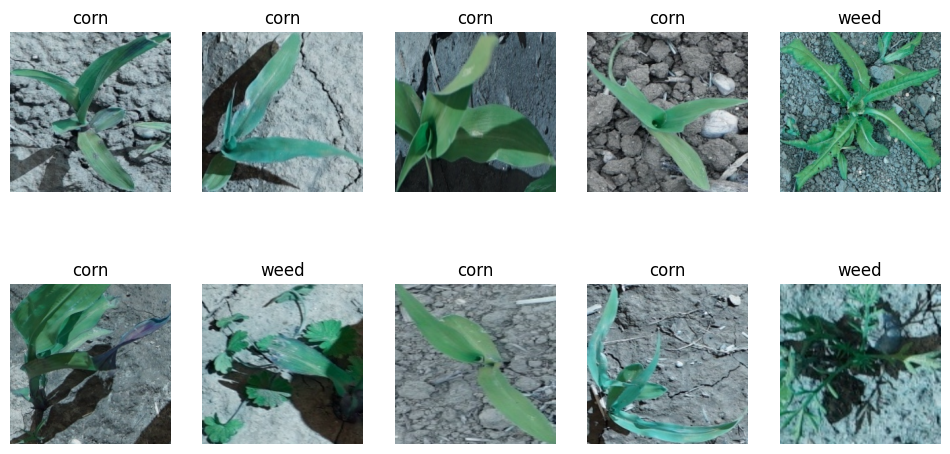

In [74]:
import matplotlib.pyplot as plt

nr_rows = 2
nr_cols = 5

fig, m_axs = plt.subplots(nr_rows, nr_cols, figsize=(12, 6))
for i in range(nr_rows):
    for j in range(nr_cols):
        temp = i*nr_cols+j
        m_axs[i, j].imshow(X_train[temp])
        if y_train[temp][0] == 1:
            m_axs[i, j].set_title('corn')
        else:
            m_axs[i, j].set_title('weed')
        m_axs[i, j].axis('off')

plt.show()

In [75]:
import gc

del train_data
del test_data
del X_train
del X_test
gc.collect()

26295

# Preprocessing, Augmentation

In [79]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [80]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    zoom_range=0.1,
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    zoom_range=0.1,
)

# Segmentation

In [81]:
# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(244, 244),
    batch_size=16,
    class_mode='categorical',
)

# Flow validation images in batches of 16 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(244, 244),
    batch_size=16,
    class_mode='categorical',
)

Found 3257 images belonging to 2 classes.
Found 363 images belonging to 2 classes.


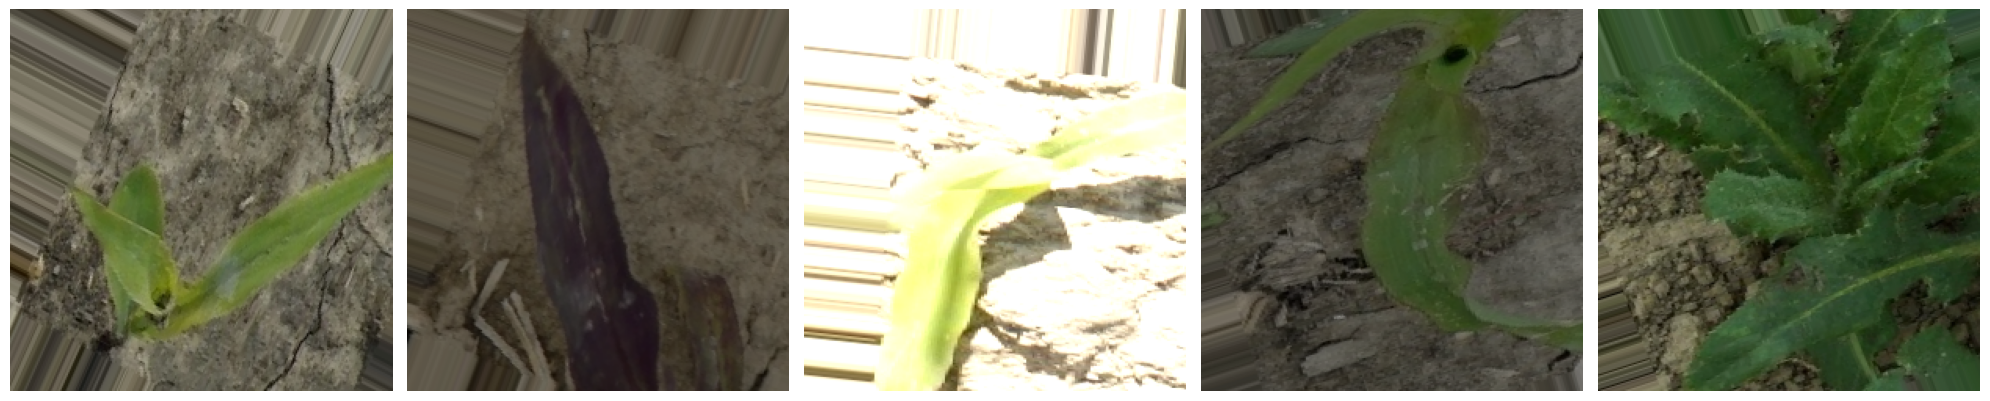

In [115]:
import matplotlib.pyplot as plt

sample_training_images, _ = next(train_generator)


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(sample_training_images[:5])

# Feature Extraction

In [83]:
import tensorflow as tf

In [84]:
model = tf.keras.models.Sequential([
    # Feature Extraction
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(244, 244, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten
    tf.keras.layers.Flatten(),

    # Fully Connected
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [85]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 242, 242, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 121, 121, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 119, 119, 32)      4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 28, 28, 64)     

In [86]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback Function

In [87]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if logs.get('accuracy') > 0.95:
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True


callbacks = myCallback()

# Training

In [88]:
history = model.fit(
    train_generator,
    batch_size=16,
    validation_data=test_generator,
    epochs=50,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/50
204/204 [==============================] - 81s 392ms/step - loss: 0.5788 - accuracy: 0.7485 - val_loss: 0.5708 - val_accuracy: 0.7493
Epoch 2/50
204/204 [==============================] - 78s 380ms/step - loss: 0.5484 - accuracy: 0.7571 - val_loss: 0.5117 - val_accuracy: 0.7521
Epoch 3/50
204/204 [==============================] - 76s 373ms/step - loss: 0.4210 - accuracy: 0.7946 - val_loss: 0.3548 - val_accuracy: 0.8264
Epoch 4/50
204/204 [==============================] - 76s 371ms/step - loss: 0.3515 - accuracy: 0.8502 - val_loss: 0.2917 - val_accuracy: 0.8705
Epoch 5/50
204/204 [==============================] - 77s 377ms/step - loss: 0.3086 - accuracy: 0.8640 - val_loss: 0.2590 - val_accuracy: 0.8788
Epoch 6/50
204/204 [==============================] - 77s 376ms/step - loss: 0.3165 - accuracy: 0.8621 - val_loss: 0.4468 - val_accuracy: 0.7658
Epoch 7/50
204/204 [==============================] - 76s 373ms/step - loss: 0.2913 - accuracy: 0.8778 - val_loss: 0.2902 - val_ac

# Save Model

In [89]:
model.save('model.h5')

# Visualization

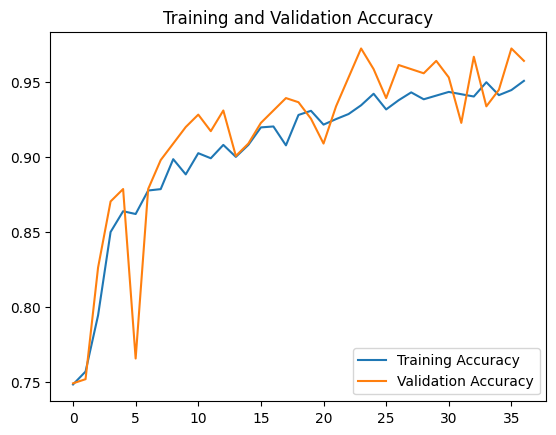

In [90]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

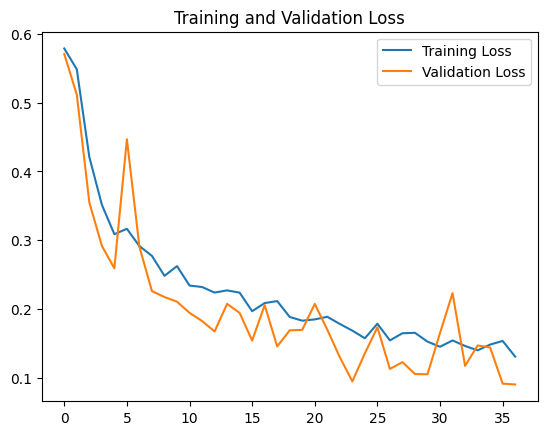

In [91]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

In [92]:
from skimage import io
import cv2
from tensorflow.keras.preprocessing import image
import os
import tensorflow as tf
import numpy as np

1/1 [==============================] - 0s 106ms/step
[[1. 0.]]
Jagung


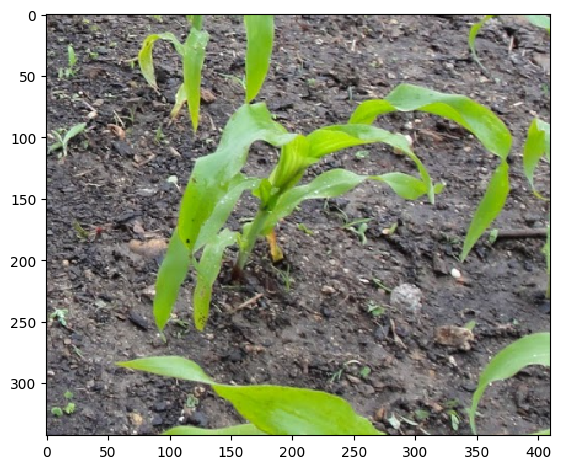

In [113]:
reconstructed_model = tf.keras.models.load_model("model.h5")

source = '../images/jagung/img.png'

img = image.load_img(source, target_size=(244, 244))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])

pred = reconstructed_model.predict(images, batch_size=10)

classes = np.argmax(pred, axis=1)

labels = ['corn', 'weed']

print(pred)

if classes[0] == 0:
    print("Jagung")
else:
    print("Gulma")

io.imshow(source)

1/1 [==============================] - 0s 86ms/step
[[4.1866454e-23 1.0000000e+00]]
Gulma


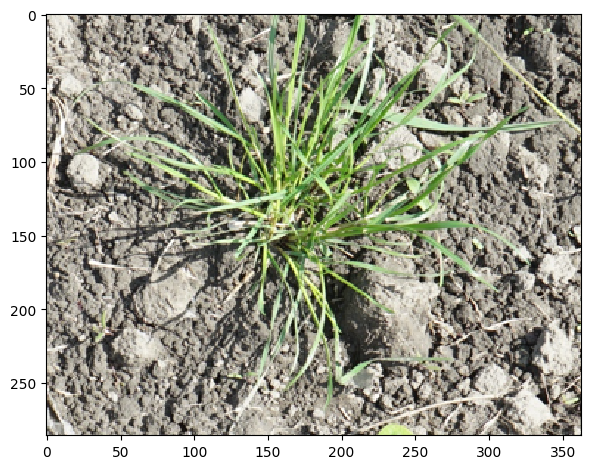

In [114]:
reconstructed_model = tf.keras.models.load_model("model.h5")

source = '../images/img.png'

img = image.load_img(source, target_size=(244, 244))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])

pred = reconstructed_model.predict(images, batch_size=10)

classes = np.argmax(pred, axis=1)

labels = ['corn', 'weed']

print(pred)

if classes[0] == 0:
    print("Jagun")
else:
    print("Gulma")

io.imshow(source)